# Выращиваем решающее дерево своими руками

### OzonMasters, "Машинное обучение 1"

В этом ноутбуке вам предлагается реализовать решающее дерево.
#Файзуллов Айрат

## Введение

Для начала импортируем библиотеки, которые нам понадобятся в дальнейшем:

In [2]:
import numpy as np

from sklearn.metrics import accuracy_score

### Решающее дерево

Вспомним, что такое решающее дерево.

Решающее дерево - алгоритм машинного обучения, задающийся специальным графом-деревом. В данном задании мы будем использовать бинарное дерево. Каждая внутренняя вершина такого дерева соответствует функции предикату $\mathbb{I}[x_{\alpha} \geq \beta]$. Каждая листовая вершина соответствует некоторому значению ответа, которое будет выдавать алгоритм (вещественное число в случае регрессии, номер класса или вектор вероятностей в случае классификации).

На этапе обучения нам необходимо построить само дерево, а также выбрать $\alpha$ и $\beta$ для каждой внутренней вершины и метку прогноза для каждой листовой вершины. Задача построения "наилучшего" дерева (например того, которое не совершает ошибок и имеет минимальное число вершин) является NP-полной, поэтому при построении деревьев на практике приходиться использовать жадные алгоритмы.

На этапе применения все объекты пропускаются через дерево. Изначально, для каждого объекта вычисляется значение функции-предиката корневой вершины. Если оно равно нулю, то алгоритм переходит в левую дочернюю вершину, иначе в правую. Затем вычисляется значение предиката в новой вершине и делается переход или влево, или вправо. Процесс продолжается, пока не будет достигнута листовая вершина. Алгоритм возвращает то значение, которое будет приписано этой вершине.

### Выбор $\alpha$ и $\beta$

На этапе построения дерева мы будем выбирать предикаты для каждой новой вершины, максимизируя функционал качества для разбиения вершины на два поддерева, который можно записать в следующем виде:
$$ Q(R, \alpha, \beta) = H(R) - \frac{|R_l|}{|R|} H(R_l) - \frac{|R_r|}{|R|} H(R_r) $$

* $H$ - критерий информативности
* $R$ - объекты в текущей вершине
* $R_r$ - объекты, попадающие в правое поддерево
* $R_l$ - объекты, попадающие в левое поддерево

Например, критерий информативности Джини для задачи классификации:

$$ H(R) = \sum_{k=1}^K p_k (1 - p_k) = 1 - \sum_{k=1}^K p_k^2 $$

* $p_k$ - доля объектов с классом $k$ среди $R$
* $K$ - общее число классов

При разбиении вершины на два поддерева мы хотим максимизировать функционал качества, оптимизируя:

* $\alpha$ - номер признака в предикате
* $\beta$ - пороговое значение предиката

В данном задании оптимизацию мы будем проводить, используя полный перебор значений. Для $\alpha$ множество перебираемых значений - все имеющиеся признаки, для $\beta$ - все встречающиеся в обучающей выборке значения каждого признака, кроме наименьшего и наибольшего.

## 1. Построение критерия и вычисление предиката

В данном пункте предлагается:
- реализовать метод `get_best_split` у абстрактного класса `Criterion`, который выполняет поиск порога разбиения $\beta$ по вектору признаков;
- для каждого из критериев `GiniCriterion`, `EntropyCriterion`, `MSECriterion` реализовать два метода:
    - `score`, считает чистоту узла, т.е. непосредственно сам критерий $H(R)$;
    - `get_predict_val`, вычисляет предсказанное значение в листе.

In [276]:
class Criterion:
    def get_best_split(self, feature, target):
        """
        Parameters
        ----------
        feature : feature vector, np.ndarray.shape = (n_samples, )
        target  : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        threshold : value to split feature vector, float
        q_value   : impurity improvement, float
        """

        indices = feature.argsort()
        N = len(feature)
        target_srt = target[indices]
        q_best = -np.inf
        i_best = None
        h_0 = self.score(target)

        for i in range(1, N):
            h_l = self.score(target_srt[:i])
            h_r = self.score(target_srt[i:])
            q = h_0 - h_l * i / N - h_r * (N - i) / N
            if q > q_best:
                q_best = q
                i_best = i

        thrl = (feature[i_best] + feature[i_best - 1]) / 2
        return thrl, q_best


    def score(self, target):
        """
        Parameters
        ----------
        target : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        impurity : float
        """

        raise NotImplementedError

    def get_predict_val(self, target):
        """
        Parameters
        ----------
        target : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        prediction :
            - classification: probability distribution in node, np.ndarray.shape = (n_classes, )
            - regression: best constant approximation, float
        """

        raise NotImplementedError


class GiniCriterion(Criterion):
    def __init__(self, n_classes):
        self.n_classes = n_classes
    
    def get_predict_val(self, classes):
        return np.bincount(classes, minlength=self.n_classes) / len(classes)

    def score(self, classes):
        pred = self.get_predict_val(classes)
        return 1 - (pred ** 2).sum()


class EntropyCriterion(Criterion):
    EPS = 1e-6
    
    def __init__(self, n_classes):
        self.n_classes = n_classes

    def get_predict_val(self, classes):
        return np.bincount(classes, minlength=self.n_classes) / len(classes)

    def score(self, classes):
        pred = self.get_predict_val(classes)
        return (-pred * np.log(pred + self.EPS)).sum()


class MSECriterion(Criterion):
    def get_predict_val(self, target):
        return np.mean(target)

    def score(self, target):
        return np.var(target)

Проверь себя:

In [4]:
target = [1, 1, 2, 4, 2, 2, 0, 1, 0, 4]
y_true = [0.2, 0.3, 0.3, 0, 0.2]
y_pred = GiniCriterion(n_classes=5).get_predict_val(target)
assert np.allclose(y_pred, y_true)

In [5]:
target = [1, 1, 2, 4, 2, 2, 0, 1, 0, 4]
scores = GiniCriterion(n_classes=5).score(target)
assert np.isclose(scores, 0.74)

In [6]:
N = 100

x = np.arange(N)
y = np.r_[np.ones(N // 2), np.zeros(N - N // 2)].astype(int)

threshold, q_best = GiniCriterion(n_classes=2).get_best_split(x, y)
assert np.isclose(threshold, 49.5)
assert np.isclose(q_best, 0.5)

## 2. Вычисление параметров предиката и разбиение вершины дерева

Ниже вам предлагается реализовать несколько методов. Для класса `TreeNode` необходимо реализовать методы:
* `get_best_split` - вычисление оптимальных $\alpha$, $\beta$ для выбранного функционалиа $Q(R, \alpha, \beta)$;
* `split` – разбиение узла с заданными подобранными параметрами.

In [7]:
class TreeNode:
    def __init__(self, impurity, predict_val, depth):
        self.impurity = impurity        # node impurity
        self.predict_val = predict_val  # prediction of node
        self.depth = depth              # current node depth
        
        self.feature = None             # feature to split
        self.threshold = None           # threshold to split
        self.improvement = -np.inf      # node impurity improvement after split
        
        self.child_left = None
        self.child_right = None
    
    @property
    def is_terminal(self):
        return self.child_left is None and self.child_right is None
    
    @classmethod
    def get_best_split(cls, X, y, criterion):
        '''
        Finds best split for current node
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        
        Returns
        -------
        feature   : best feature to split,  int
        threshold : value to split feature, float
        q_value   : impurity improvement,   float
        '''

        q_best = -np.inf
        t_best = None
        f_best = None

        for fi in range(X.shape[1]):
            thr, q = criterion.get_best_split(X[:, fi], y)
            if q > q_best:
                q_best = q
                t_best = thr
                f_best = fi

        return f_best, t_best, q_best
    
    def get_best_split_mask(self, X):
        '''
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        
        Returns
        -------
        right_mask : indicates samples in right node after split
            np.ndarray.shape = (n_samples, )
            np.ndarray.dtype = bool
        '''

        return X[:, self.feature] >= self.threshold
    
    def split(self, X, y, criterion, **split_params):
        '''
        Split current node
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : criterion to split by, Criterion
        split_params : result of get_best_split method
        
        Returns
        -------
        right_mask : indicates samples in right node after split
            np.ndarray.shape = (n_samples, )
            np.ndarray.dtype = bool
            
        child_left  : TreeNode
        child_right : TreeNode
        '''
        
        self.feature = split_params['feature']
        self.threshold = split_params['threshold']
        self.improvement = split_params['improvement']

        mask_right = self.get_best_split_mask(X)
        
        self.child_right = self.from_criterion( y[mask_right], criterion, self.depth + 1)
        self.child_left = self.from_criterion(y[~mask_right], criterion, self.depth + 1)

        return mask_right, self.child_left, self.child_right
    
    @classmethod
    def from_criterion(cls, y, criterion, depth=0):
        return cls(
            impurity=criterion.score(y),
            predict_val=criterion.get_predict_val(y),
            depth=depth,
        )

Проверьте себя:

In [8]:
N, M = 100, 10
f = 3

criterion = GiniCriterion(n_classes=2)
x = np.c_[[np.arange(N) if f == fi else np.random.random(size=N) for fi in range(M)]].T
y = np.r_[np.ones(N // 2), np.zeros(N - N // 2)].astype(int)

In [9]:
best_feature, best_threshold, improvement = TreeNode.get_best_split(x, y, criterion)

assert best_feature == f
assert best_threshold == 49.5
assert improvement == 0.5

## 3. Реализация дерева.

Вот мы и добрались до самого важного. В классе `DecisionTree` вам необходимо реализовать следующие методы:
* fit - обучения дерева
* predict - выдача предсказаний по дереву

Дерево предлагается строить самым простым способом – рекурсивно. Для реализации предлагается использовать два вспомогательных метода: 
* `_build_nodes` - вспомогательный рекурсивный метод для fit, разделяет вершину на две, если не выполняются условия останова;
* `_get_nodes_predictions` - вспомогательный рекурсивный метод для predict, пропускает объекты через вершины и заполняет матрицу предсказаний.

Важный вопрос при реализации: как выбрать критерий останова создания новой вершины?

Вершина не будет разветвляться, если выполнено хотя бы одно из четырех условий:
* если вершина на глубине `max_depth`;
* если в вершине меньше, чем `min_leaf_size` объектов;
* если в вершине все объекты имеют одинаковые метки;
* если функционал качества не увеличивается больше, чем на `min_improvement`.

Также для интерпретации важности признаков, участвующих в построении дерева, предлагается реализовать метод-свойство `feature_importances_`.

In [380]:
from collections import deque


class DecisionTree:
    def __init__(self, max_depth=None, min_leaf_size=None, min_improvement=None):
        self.criterion = None
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.min_improvement = min_improvement

    def _build_nodes(self, X, y, criterion, indices, node):
        '''
        Builds tree recursively
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : criterion to split by, Criterion
        indices : samples' indices in node,
            np.ndarray.shape = (n_samples, )
            nd.ndarray.dtype = int
        node : current node to split, TreeNode
        '''
        
        if (self.max_depth is not None and node.depth >= self.max_depth) or \
        (self.min_leaf_size is not None and self.min_leaf_size > len(indices)) or \
        (np.unique(y[indices]).shape[0] <= 1):
            # will remember info on leaves
            answers = criterion.get_predict_val(y[indices])
            node.leaves = answers
            return

        X_node = X[indices]
        y_node = y[indices]

        feature, threshold, improvement = node.get_best_split(X_node, y_node, criterion)

        if self.min_improvement is not None and self.min_improvement > improvement:
          answers = criterion.get_predict_val(y[indices])
          node.leaves = answers
          return

        mask_right, child_left, child_right = node.split(
            X_node, y_node, criterion,
            feature=feature,
            threshold=threshold,
            improvement=improvement
        )

        # len(indices) == len(X_node)
        # => mask_right also corresponds to indices
        self._build_nodes(X, y, criterion, indices[~mask_right], child_left)
        self._build_nodes(X, y, criterion, indices[mask_right], child_right)
        
    def _get_nodes_predictions(self, X, predictions, indices, node):
        '''
        Builds tree recursively
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        predictions : result matrix to be feild,
            - classification : np.ndarray.shape = (n_samples, n_classes)
            - regression : np.ndarray.shape = (n_samples, )
        indices : samples' indices in node,
            np.ndarray.shape = (n_samples, )
            nd.ndarray.dtype = int
        node : current node to split, TreeNode
        '''
        if node.is_terminal:
            predictions[indices] = node.leaves
            return
        mask = node.get_best_split_mask(X[indices])
        self._get_nodes_predictions(X, predictions, indices[~mask], node.child_left)
        self._get_nodes_predictions(X, predictions, indices[mask], node.child_right)
        # print(node.leaves)
    
    @property
    def feature_importances_(self):
        '''
        Returns
        -------
        importance : cummulative improvement per feature, np.ndarray.shape = (n_features, )
        '''
        importance = np.zeros(self.n_features_)
        queue = deque()
        queue.append(self.root_)

        while len(queue):
            node = queue.popleft()
            if node.is_terminal:
                continue

            importance[node.feature] += node.improvement
            queue.append(node.child_left)
            queue.append(node.child_right)

        return importance

А теперь на основе реализованного в общем виде дерева, сделаем дерево для классификации:

In [381]:
class ClassificationDecisionTree(DecisionTree):
    def __init__(self, criterion='gini', **kwargs):
        super().__init__(**kwargs)
        
        if criterion not in ('gini', 'entropy', ):
            raise ValueError('Unsupported criterion', criterion)
        self.criterion = criterion
            
    def fit(self, X, y):
        self.n_classes_ = np.max(y) + 1
        self.n_features_ = X.shape[1]
        
        if self.criterion == 'gini':
            criterion = GiniCriterion(n_classes=self.n_classes_)
        elif self.criterion == 'entropy':
            criterion = EntropyCriterion(n_classes=self.n_classes_)
        else:
            raise ValueError('Unsupported criterion', criterion)

        self.root_ = TreeNode.from_criterion(y, criterion)
        self._build_nodes(X, y, criterion, np.arange(X.shape[0]), self.root_)

        return self
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)
    
    def predict_proba(self, X):
        probas = np.zeros(shape=(X.shape[0], self.n_classes_))
        self._get_nodes_predictions(X, probas, np.arange(X.shape[0]), self.root_)
        return probas

Проверь себя:

In [382]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [383]:
some_X.shape, some_y.shape

((400, 2), (400,))

In [384]:
assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

In [385]:
assert (some_tree.feature_importances_ == [0.25, 1.  ]).all()

Ещё одна проверка:

In [386]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

some_X = np.hstack((some_X, np.random.random((400, 100))))

some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [387]:
assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

## 4. Визуализация результатов

Давайте проверим, что дерево работает на нескольких модельных задачах.

In [388]:
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
%matplotlib inline

Функция для визуализации двумерной выборки:

In [389]:
def plot_data(X, y, figsize=(6, 5)):
    plt.figure(figsize=figsize)
    
    n_classes = y.max() + 1
    for i in range(n_classes):
        plt.plot(X[:, 0][y == i], X[:, 1][y == i], 'o')

Функция для визуализации работы дерева на двумерной выборке:

In [390]:
def plot_decision_surface(clf, X, y, plot_step=0.2, cmap='Spectral', figsize=(6, 5)):
    # Plot the decision boundary
    plt.figure(figsize=figsize)
    
    n_classes = len(set(y))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)    
    y_pred = clf.predict(X)

    # Plot the training points
    plt.scatter(*X[y_pred == y].T, marker='.', s=70,
                c=y[y_pred == y], cmap=cmap, alpha=0.9, label='correct')
    plt.scatter(*X[y_pred != y].T, marker='x', s=50,
                c=y[y_pred != y], cmap=cmap, label='errors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(loc='best')
    print("Accuracy =", accuracy_score(y, y_pred))

Для начала рассмотрим простую задачу с полностью разделимыми по некоторому признаку классами:

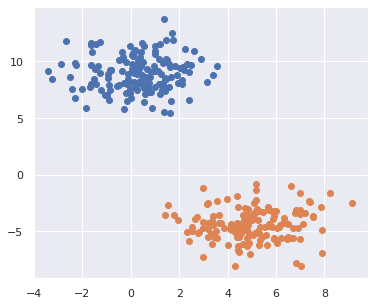

In [391]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=1.5, centers=2, random_state=23)

plot_data(X, y)

Применим к этой задаче алгоритм "решающий пень":

In [392]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

Если вы всё реализовали правильно, то должно получиться что-то такое:

Accuracy = 1.0


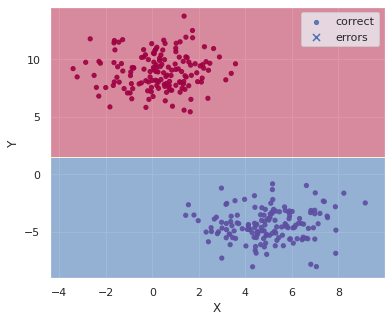

In [393]:
plot_decision_surface(some_tree, X, y)

Теперь рассмотрим более сложную задачу с плохо разделимыми классами:

In [394]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=2, centers=5, random_state=23)

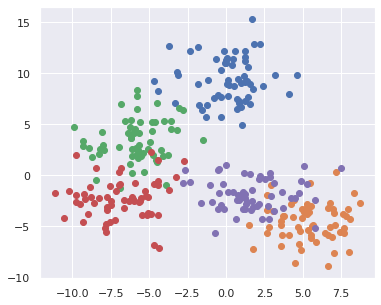

In [395]:
plot_data(X, y)

Посмотрим на результаты, которые получаются при разных значениях глубины:

Accuracy = 0.37333333333333335


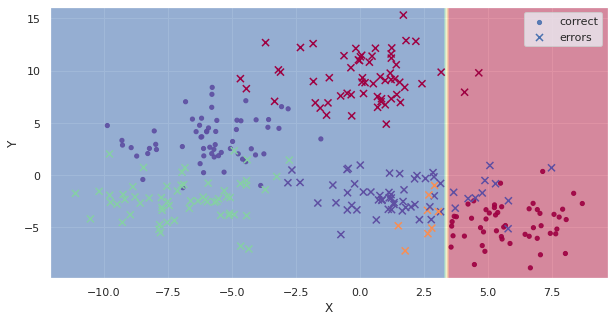

In [396]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.5633333333333334


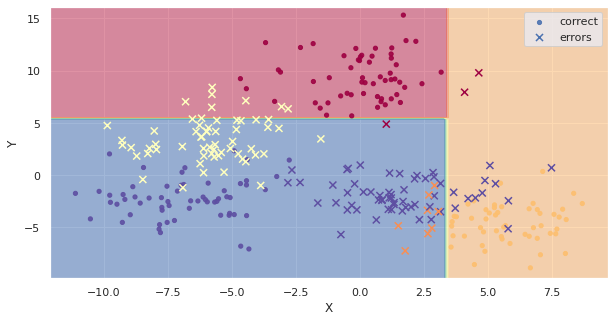

In [397]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.7233333333333334


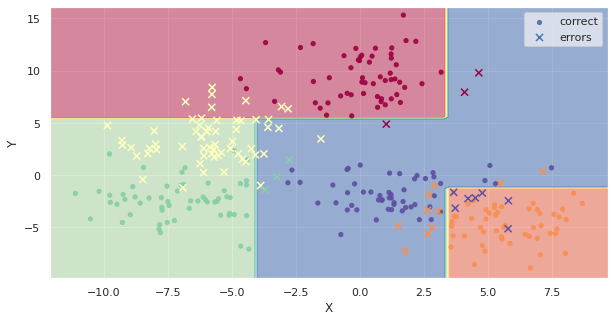

In [398]:
some_tree = ClassificationDecisionTree(max_depth=3, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.8533333333333334


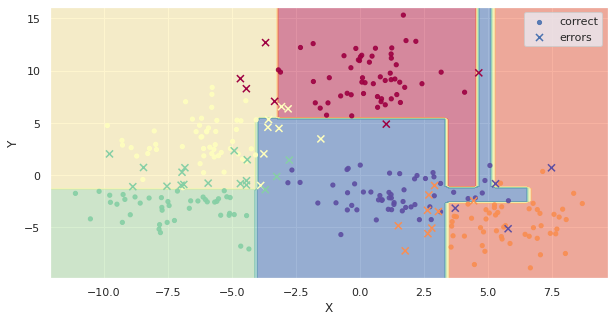

In [399]:
some_tree = ClassificationDecisionTree(max_depth=5, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.9966666666666667


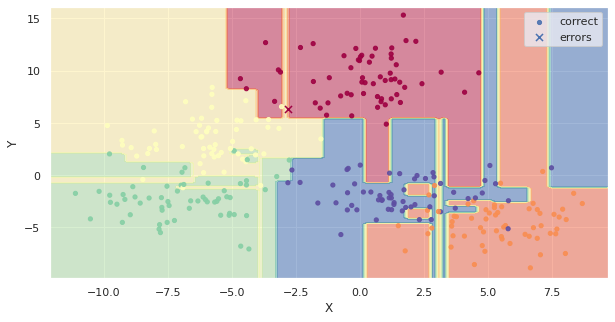

In [400]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Можно заметить, что начиная с некоторого значения глубины, дерево начинает сильно переобучаться (новые сплиты пытаются описать максимум 1-2 объекта). Это можно поправить, изменяя параметр `min_leaf_size` или `min_improvement`.

Accuracy = 0.8866666666666667


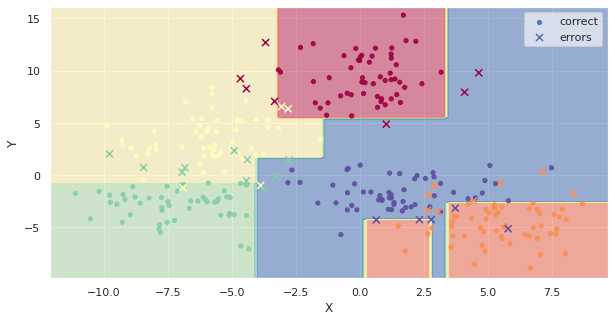

In [401]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=10)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.98


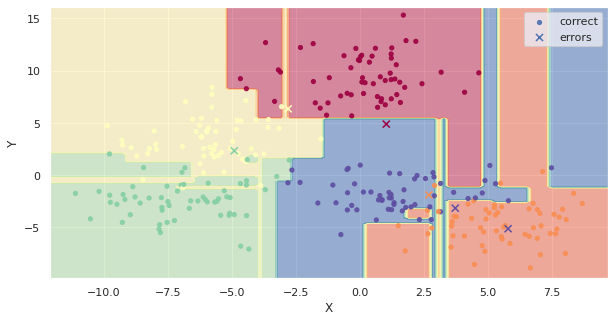

In [402]:
some_tree = ClassificationDecisionTree(max_depth=10, min_improvement=0.08)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

## Домашнее задание (10 баллов)

1. (4 балла) Доделать все пункты ноутбука до конца

2. (2 балла) Для регрессионного дерева необходимо использовать такой критерий:
    $$
    H(R) = \min_c \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2
    $$
    
    Докажите, что минимум H(R) достигается при $c$:

    $$ c = \frac{1}{|R|} \sum_{(x_j, y_j) \in R} y_j$$

3. (2 балла) Реализуйте регрессионное дерево. В качестве критерия необходимо использовать критерий, определённый в пункте 2. В качестве функции выдачи результатов необходимо использовать среднее значение ответов по всем объектам в листе.

    Сгенерируйте однопризнаковую выборку для тестирования дерева и покажите работу дерева на этой выборке. Отобразите на одном графике значения алгоритма и точки. Нарисуйте эту картинку для нескольких значений глубины. Сделайте выводы.
    
    
3. (2 балла) Протестируйте ваше дерево на california_housing датасете (можно загрузить с помощью sklearn.datasets.fetch_california_housing).
    Разбейте данные на обучение, контроль и тест. Подберите гиперпараметры по контрольной выборке, покажите качество алгоритма на тестовой. Сделайте выводы.


Бонусных баллов в этот раз нет :)

При $$c = \frac{1}{|R|} \sum_{(x_j, y_j) \in R} y_j$$ H(R) будет достигать минимума, т.к. $$ H(R) = \min_c \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2$$ Видно из формулы, что мы ищем минимуальную сумму, поэтому лучше всего подойдет значение $c$, которое удалено от всех $y_i$ на равные расстояния. И чтобы этого добиться, лучше всего подойдет возможность с подсчсетом $c$ в прдставлении среднего арифметического, как и было указано в первой формуле.

In [272]:
class Regression(DecisionTree):
  def __init__(self, criterion='MSE', **kwargs):
        super().__init__(**kwargs)
        self.criterion = criterion
  
  def fit(self, X, y):
    self.n_features_ = X.shape[1]
    if self.criterion == 'MSE':
        criterion = MSECriterion()
    else:
        raise ValueError('Unsupported criterion', criterion)
    self.root_ = TreeNode.from_criterion(y, criterion)
    self._build_nodes(X, y, criterion, np.arange(len(X)), self.root_)
    return self

  def predict(self, X):
    answers = np.zeros(len(X)) 
    self._get_nodes_predictions(X, answers, np.arange(len(X)), self.root_)
    return answers

In [146]:
import seaborn as sns
import random
sns.set_theme()

In [360]:
def create_data(X):
  j = 0
  y = np.zeros(len(X))
  for i in X:
    y[j] = i**2 + random.random() * 1.5
    j += 1 
  return y


In [361]:
dots = [random.randrange(start=-5, stop=5, step=2) for i in range(5)]
dots = random.sample(list(np.arange(-2, 2, 0.1)), 40)
ans2 = create_data(dots)

Создали выборку для тестирования

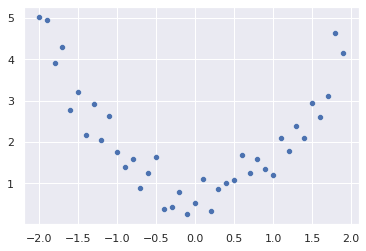

In [362]:
sns.scatterplot(x=dots, y=ans2)


In [371]:
def give_plot(deph, leaf):
  to_regr = Regression(max_depth=deph, min_leaf_size=leaf)
  sort_dots = dots.copy()
  sort_dots.sort()
  arr_dots = (np.array(sort_dots)[np.newaxis]).T
  to_regr.fit(np.array(dots)[np.newaxis].T, np.array(ans2))
  y_regr = to_regr.predict(arr_dots)
  label_str = "mse for" + str(deph)
  plt.plot(sort_dots, y_regr, label=label_str, c='red')
  plt.scatter(x=dots, y=ans2, label='dots')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.legend(loc='best')

Работа регрессионого алгоритма, при глубине дерева равное 1

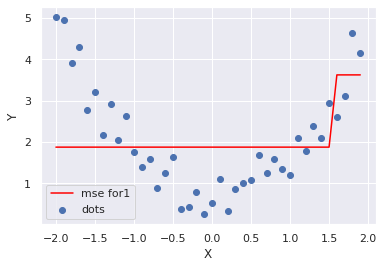

In [373]:
give_plot(1, 1)

Работа регрессионого алгоритма, при глубине дерева равное 3

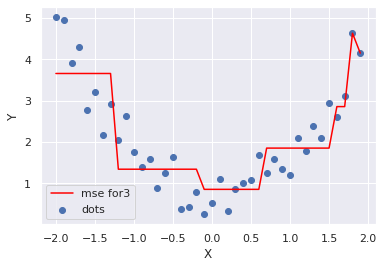

In [378]:
give_plot(3, 1)

Работа регрессионого алгоритма, при глубине дерева равное 5

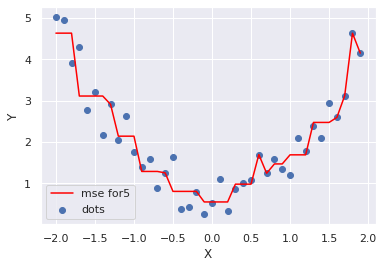

In [377]:
give_plot(5, 1)

Работа регрессионого алгоритма, при глубине дерева равное 12

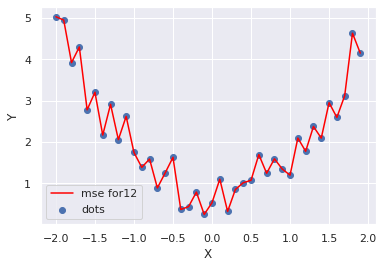

In [379]:
give_plot(12, 1)

Видим, что при большой глубине дерева у нас происходит переобучение. Наиболее эффективное дерево - дерево с глубиной 3, т.к. оно наиболее четко показывает тенденции в изменении полложения точек

In [403]:
from sklearn.datasets import fetch_california_housing

Разделяю данные на обучение контроль и тест

In [416]:
X, Y = fetch_california_housing(return_X_y=True)
X_train = X[:12000]
Y_train = Y[:12000]
X_contr = X[12000:15000]
Y_contr = Y[12000:15000]
X_test = X[15000:]
Y_test = Y[15000:] 

In [413]:
%pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.3 MB/s 
     |████████████████████████████████| 81 kB 8.8 MB/s 
     |████████████████████████████████| 209 kB 63.0 MB/s 
     |████████████████████████████████| 78 kB 7.1 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
     |████████████████████████████████| 147 kB 60.4 MB/s 
     |████████████████████████████████| 112 kB 61.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=139c48db8a3074309c78198ce9d447a5b7e5cc923ea64857ae9d24c81584d21d
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip


In [414]:
import optuna

In [427]:
def our_objective(trial):
  tmp = {
    'max_depth': trial.suggest_int('max_depth', 1, 20),
    'min_leaf_size': trial.suggest_int('min_leaf_size', 0, 200),
  }
  model = Regression(**tmp)
  model.fit(X_train, Y_train)
  our_ans = model.predict(X_contr)
  return np.mean((our_ans - Y_contr) ** 2)

study = optuna.create_study(direction='minimize')
study.optimize(our_objective, n_trials=12, n_jobs=3)

[I 2022-12-12 04:28:53,101] A new study created in memory with name: no-name-461b5d9e-8bf3-4f43-8be5-e3c192ae88ad
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:254: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars

[I 2022-12-12 04:31:55,003] Trial 2 finished with value: 0.5714686275967816 and parameters: {'max_depth': 4, 'min_leaf_size': 191}. Best is trial 2 with value: 0.5714686275967816.
[I 2022-12-12 04:33:13,573] Trial 0 finished with value: 0.5233801544518695 and parameter

In [428]:
from optuna.visualization import plot_slice

plot_slice(study)

In [429]:
print(study.best_params)

{'max_depth': 17, 'min_leaf_size': 73}


Видим, что выгодно брать не очень большое max_depth, чтобы не было переобучения. И также не стоит брать малые значение min_leaf_size

In [430]:
best_model = Regression(**study.best_params)
best_model.fit(X_train, Y_train)
answer = best_model.predict(X_test)
print(np.mean((answer - Y_test) ** 2))

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:254: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



0.7621486513696991


Вижу, что ошибка на тестовой выборке больше чем на контрольной. Вероятнее всего это произошло из-за не лучшего разбиения данных